<a href="https://colab.research.google.com/github/romera-rocio/Titanic_Rocio_Romera/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estructura

* Hipótesis

* EDA básico

* Ingeniería de variables avanzada

* Preprocesamiento (numérico + categórico)

* Pipelines

* Modelos (Decision Tree, KNN, Random Forest)

* Selección del mejor modelo

* Matrices de confusión

* ROC AUC

* Predicción final para test.csv




## Importacion de Data set

In [3]:
!pip install kaggle


In [4]:
from google.colab import files
files.upload()   # elegís kaggle.json desde tu PC


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rociobelenromerasily","key":"208666ac7f2897d87da9c755267e4620"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!unzip titanic.zip


titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Importacion de librerias



1.   Preprosesamiento y Graficos : Pandas , Numpy, Matplotlib y Seaborn

2.   PostProcesamiento: Scikit-learn( algoritmos de aprendizaje automático ) y SciPy ( Test estadisticos )





In [26]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Preprocessing & ML
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Estadística
from scipy.stats import zscore, iqr, shapiro, ks_2samp
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")


## Exploracion de Data Set

Train contiene la variable objetivo Survived.
Test no incluye Survived, por lo que se usa solo para predicción.
gender_submission es un archivo de ejemplo proporcionado por Kaggle.

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Analisis Estadistico Descriptivo

### Conclusiones preliminares del EDA básico

- El dataset contiene **891 observaciones y 12 variables**.
- `Survived` no tiene valores faltantes → modelo supervisado completo.
- `Age` tiene ~19.9% de NA → requiere imputación estadística (mediana o MICE).
- `Cabin` tiene ~77% NA → no puede usarse directamente; convertir a indicador o descartar.
- `Embarked` tiene 2 NA → imputación por moda.
- Variables numéricas (`Fare`) muestran alta asimetría.
- La serie temporal de edades sugiere distribución no normal.


In [10]:
print("Información general del dataset:")
train.info()

print("\nValores faltantes por columna:")
print(train.isna().sum())

train.describe()


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Valores faltantes por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare    

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Análisis celda por celda (valores faltantes)

- **Cabin (77.1%)** → pérdida extrema → se descarta o se transforma en binaria.
- **Age (19.8%)** → ausencias moderadas → imputación recomendada.
- **Embarked (0.22%)** → imputación por moda, sin impacto estadístico.
- El resto de las columnas no presentan NA.


In [36]:
missing = train.isna().mean().sort_values(ascending=False) * 100
missing


,0
Cabin,77.104377
Age,19.865320
Embarked,0.224467
PassengerId,0.000000
Name,0.000000
Pclass,0.000000
Survived,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000


## Análisis Exploratorio Visual (EDA visual)



- **Sexo:** Mujeres ≈ 74% sobreviven; hombres ≈ 19%.
- **Clase:** Clase 1 y 2 muestran mayor supervivencia.
- **Edad:** Distribución asimétrica; picos en 20–30 años.


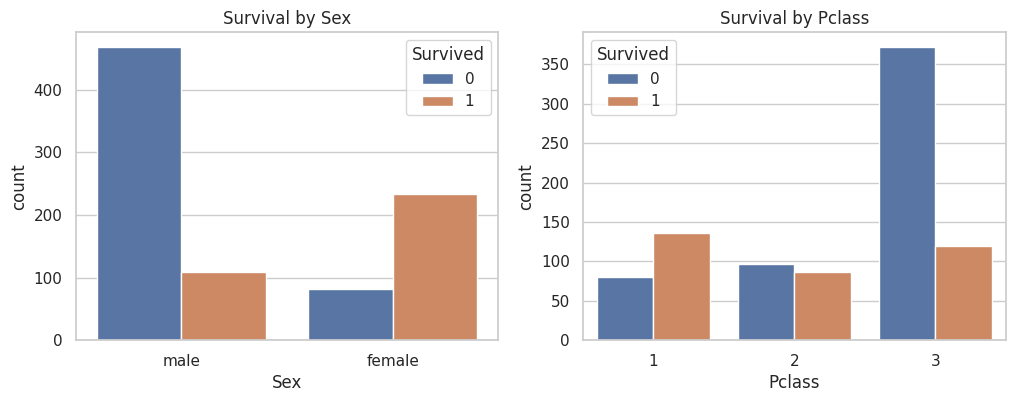

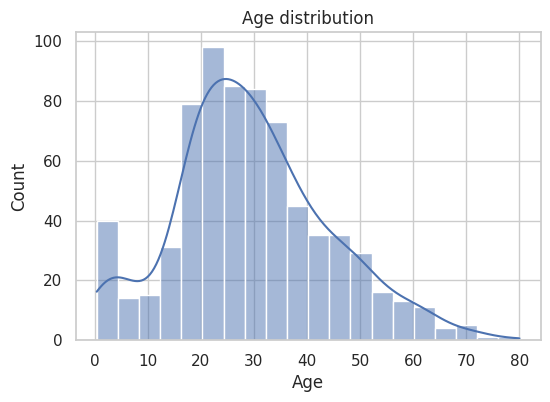

In [37]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

sns.countplot(data=train, x='Sex', hue='Survived', ax=axes[0])
axes[0].set_title('Survival by Sex')

sns.countplot(data=train, x='Pclass', hue='Survived', ax=axes[1])
axes[1].set_title('Survival by Pclass')

plt.figure(figsize=(6,4))
sns.histplot(train['Age'].dropna(), kde=True)
plt.title('Age distribution')
plt.show()


#TESTS ESTADÍSTICOS Y OUTLIERS

In [27]:
num_cols = ["Age", "Fare"]

for col in num_cols:
    print("\n========================")
    print(f"OUTLIERS EN: {col}")
    print("========================")

    # Z-score rule
    z = np.abs(zscore(train[col].dropna()))
    out_z = (z > 3).sum()
    print(f"Z-score > 3: {out_z} outliers")

    # IQR rule
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    I = Q3 - Q1
    lower = Q1 - 1.5*I
    upper = Q3 + 1.5*I
    out_iqr = ((train[col] < lower) | (train[col] > upper)).sum()
    print(f"IQR Rule: {out_iqr} outliers")

    # Suggested winsorization
    print(f"Sugerencia winsorización → límites: [{lower:.2f}, {upper:.2f}]")



OUTLIERS EN: Age
Z-score > 3: 2 outliers
IQR Rule: 11 outliers
Sugerencia winsorización → límites: [-6.69, 64.81]

OUTLIERS EN: Fare
Z-score > 3: 20 outliers
IQR Rule: 116 outliers
Sugerencia winsorización → límites: [-26.72, 65.63]


#2. Normalidad de las variables numéricas

In [28]:
for col in num_cols:
    print("\n========================")
    print(f"TESTS DE NORMALIDAD: {col}")
    print("========================")

    # Shapiro–Wilk
    w, p = shapiro(train[col].dropna())
    print(f"Shapiro–Wilk p-value = {p:.5f}")

    # KS entre sobrevivientes y no sobrevivientes
    a = train.loc[train["Survived"] == 1, col].dropna()
    b = train.loc[train["Survived"] == 0, col].dropna()
    ks_stat, ks_p = ks_2samp(a, b)
    print(f"KS test Survived vs No— KS p = {ks_p:.5f}")



TESTS DE NORMALIDAD: Age
Shapiro–Wilk p-value = 0.00000
KS test Survived vs No— KS p = 0.12277

TESTS DE NORMALIDAD: Fare
Shapiro–Wilk p-value = 0.00000
KS test Survived vs No— KS p = 0.00000


# 3. Correlaciones mixtas (según tipo de variable)
Pearson → Numéricas
Spearman → Ordinales (Pclass)
Cramér’s V → Categóricas nominales

In [33]:
from scipy.stats import pearsonr, spearmanr, chi2_contingency
import numpy as np

import numpy as np

def cramers_v(confusion_matrix):
    """Cramér’s V con corrección de bias (Bergsma & Wicher, 2013)."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Bias correction
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)

    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))


print("\n=== Correlación Pearson (Age, Fare) con Survived ===")
for col in ["Age", "Fare"]:
    data = train[[col, "Survived"]].dropna()
    r, p = pearsonr(data[col], data["Survived"])
    print(f"{col}: r={r:.3f}, p={p:.5f}")

print("\n=== Spearman para Pclass ===")
rho, p = spearmanr(train["Pclass"], train["Survived"])
print(f"Spearman rho = {rho:.3f}, p = {p:.5f}")

print("\n=== Cramér's V para Sex, Embarked ===")
for col in ["Sex", "Embarked"]:
    cm = pd.crosstab(train[col], train["Survived"])
    v = cramers_v(cm)
    print(f"{col}: V = {v:.3f}")



=== Correlación Pearson (Age, Fare) con Survived ===
Age: r=-0.077, p=0.03912
Fare: r=0.257, p=0.00000

=== Spearman para Pclass ===
Spearman rho = -0.340, p = 0.00000

=== Cramér's V para Sex, Embarked ===
Sex: V = 0.540
Embarked: V = 0.166


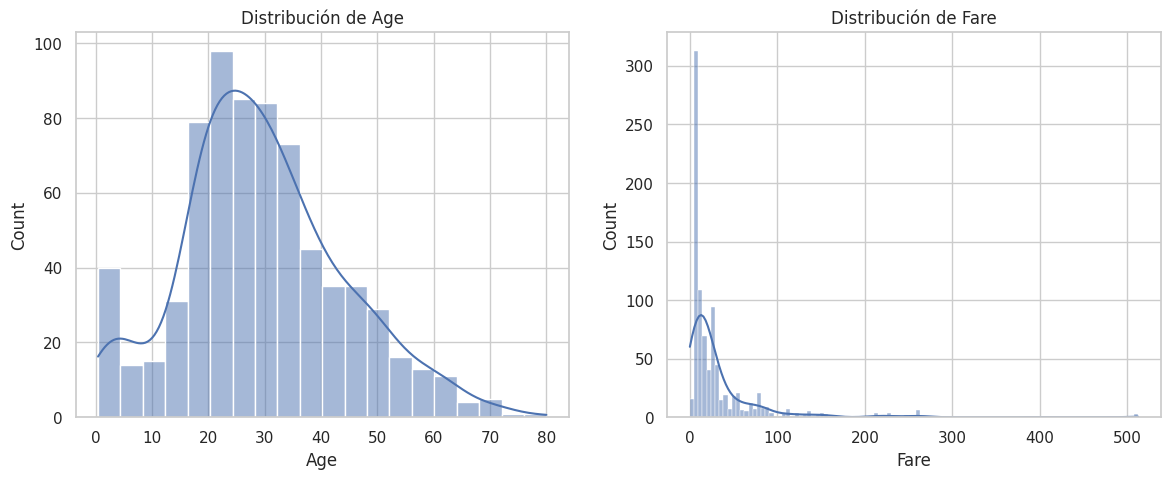

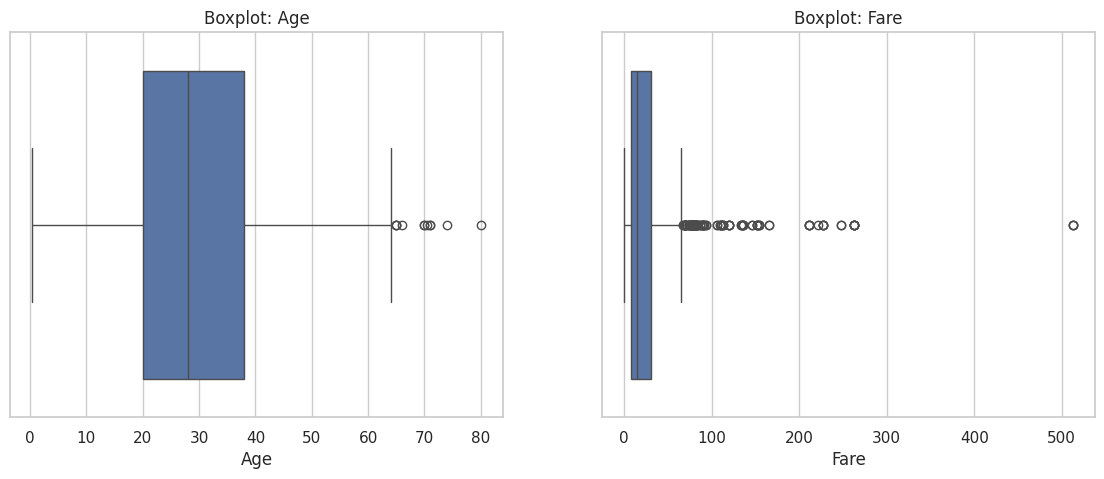

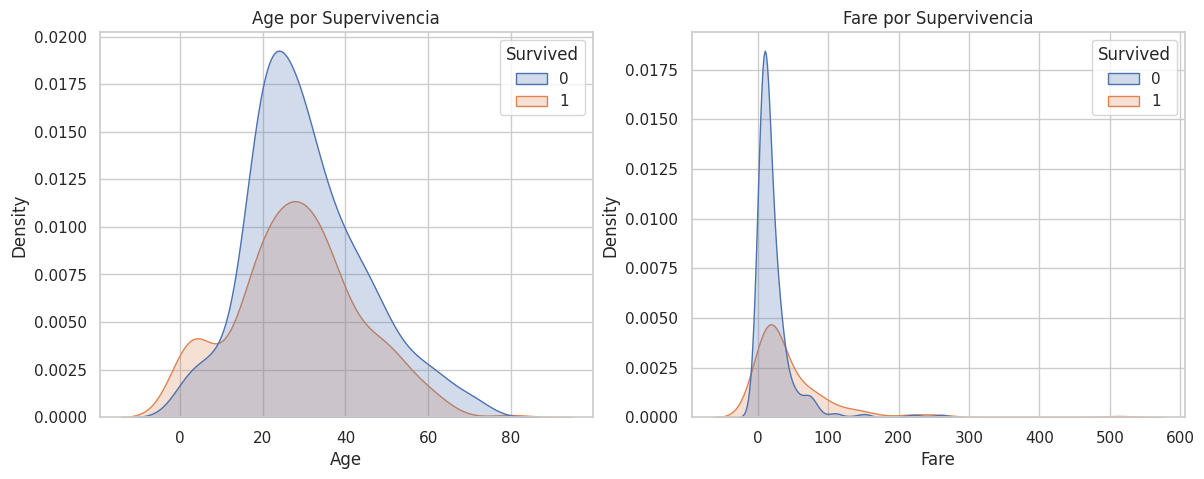

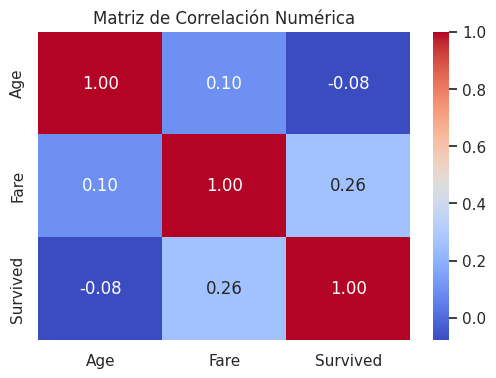

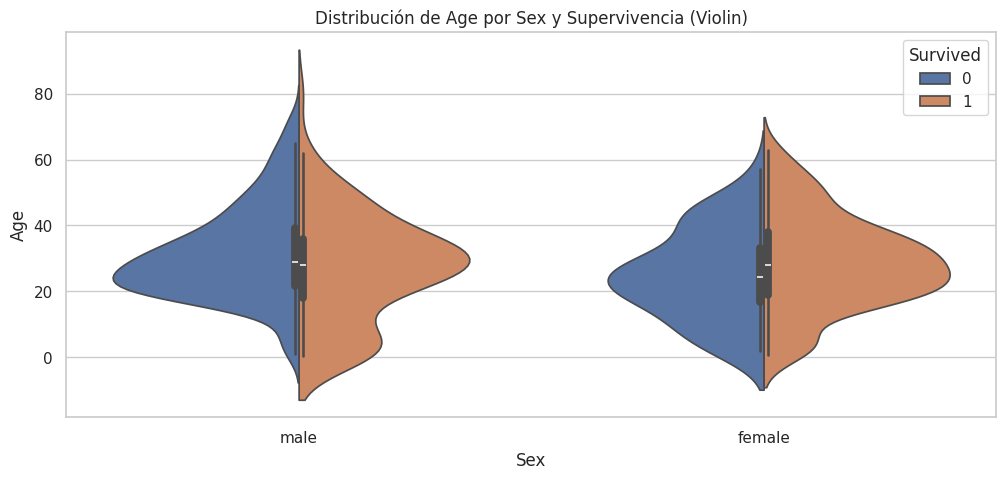

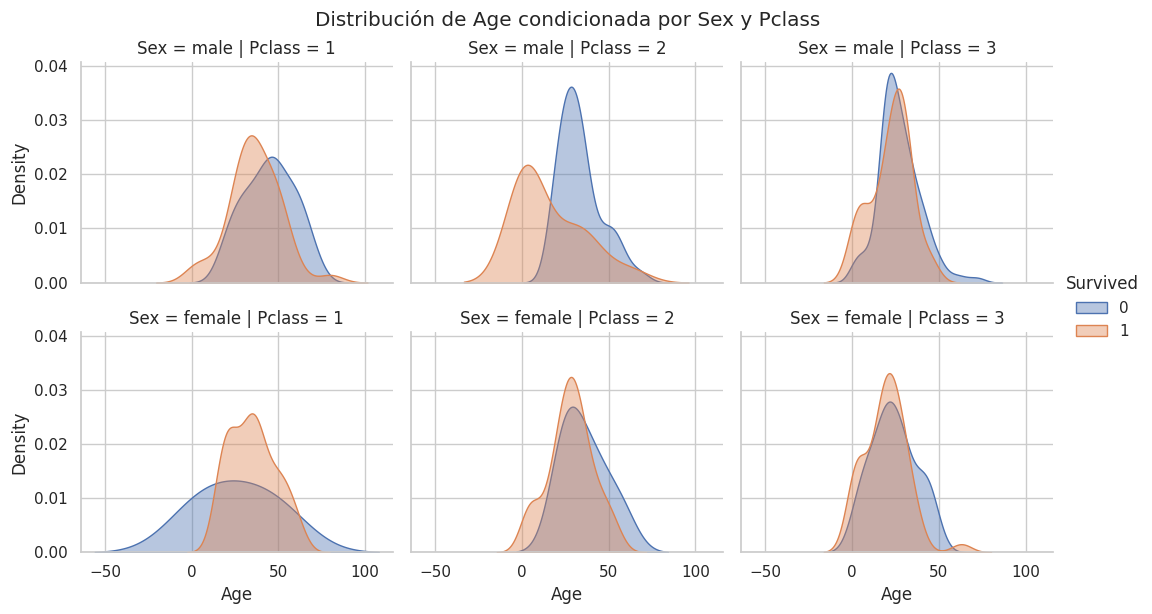

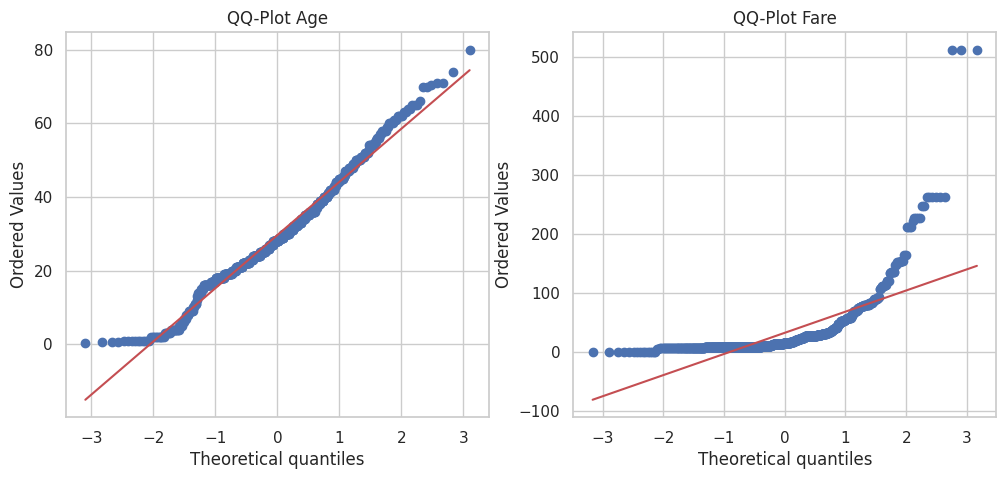

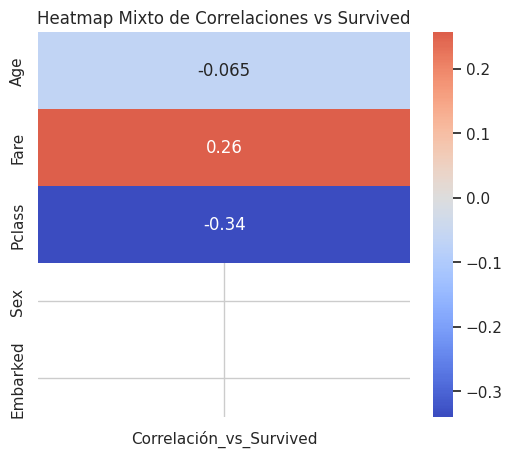

In [34]:
# ============================================================
# EDA AVANZADO – Visualizaciones estadísticas
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, pearsonr, spearmanr, chi2_contingency
import numpy as np
import pandas as pd

sns.set(style="whitegrid")

# ------------------------------------------------------------
# 1. Distribución de Age & Fare
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(train["Age"], kde=True, ax=axes[0])
axes[0].set_title("Distribución de Age")

sns.histplot(train["Fare"], kde=True, ax=axes[1])
axes[1].set_title("Distribución de Fare")

plt.show()


# ------------------------------------------------------------
# 2. Boxplots para inspección de outliers
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x=train["Age"], ax=axes[0])
axes[0].set_title("Boxplot: Age")

sns.boxplot(x=train["Fare"], ax=axes[1])
axes[1].set_title("Boxplot: Fare")

plt.show()


# ------------------------------------------------------------
# 3. KDE condicionado por supervivencia
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(data=train, x="Age", hue="Survived", fill=True, ax=axes[0])
axes[0].set_title("Age por Supervivencia")

sns.kdeplot(data=train, x="Fare", hue="Survived", fill=True, ax=axes[1])
axes[1].set_title("Fare por Supervivencia")

plt.show()


# ------------------------------------------------------------
# 4. Matriz de correlación numérica básica
# ------------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.heatmap(train[["Age", "Fare", "Survived"]].corr(), annot=True,
            cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación Numérica")
plt.show()


# ============================================================
# EDA TÉCNICO – Gráficos de nivel universitario
# ============================================================

# ------------------------------------------------------------
# 5. Violines por Sex × Survived
# ------------------------------------------------------------
plt.figure(figsize=(12, 5))
sns.violinplot(data=train, x="Sex", y="Age", hue="Survived", split=True)
plt.title("Distribución de Age por Sex y Supervivencia (Violin)")
plt.show()


# ------------------------------------------------------------
# 6. FacetGrid Age × Sex × Pclass
# ------------------------------------------------------------
g = sns.FacetGrid(train, col="Pclass", row="Sex", hue="Survived",
                  height=3, aspect=1.2)
g.map(sns.kdeplot, "Age", common_norm=False, fill=True, alpha=0.4)
g.add_legend()
plt.suptitle("Distribución de Age condicionada por Sex y Pclass", y=1.02)
plt.show()


# ------------------------------------------------------------
# 7. QQ-plots: evaluación visual de normalidad
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

probplot(train["Age"].dropna(), plot=ax[0])
ax[0].set_title("QQ-Plot Age")

probplot(train["Fare"].dropna(), plot=ax[1])
ax[1].set_title("QQ-Plot Fare")

plt.show()


# ------------------------------------------------------------
# 8. Heatmap mixto (Pearson, Spearman y Cramér's V)
# ------------------------------------------------------------
def cramers_v(cm):
    chi2 = chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

corr_data = {
    "Age": pearsonr(train["Age"].fillna(train["Age"].median()), train["Survived"])[0],
    "Fare": pearsonr(train["Fare"], train["Survived"])[0],
    "Pclass": spearmanr(train["Pclass"], train["Survived"])[0],
    "Sex": cramers_v(pd.crosstab(train["Sex"], train["Survived"])),
    "Embarked": cramers_v(pd.crosstab(train["Embarked"], train["Survived"]))
}

corr_df = pd.DataFrame(corr_data, index=["Correlación_vs_Survived"]).T

plt.figure(figsize=(6, 5))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap Mixto de Correlaciones vs Survived")
plt.show()


## Conclusiones del Análisis Exploratorio

- El dataset contiene **891 registros y 12 variables**.
- La variable objetivo **Survived** no presenta valores faltantes.
- **Age** tiene ~20% de valores faltantes → requiere imputación (preferible mediana).
- **Cabin** posee ~77% de faltantes → descartarla o convertir en indicador binario.
- **Embarked** tiene solo 2 valores faltantes → imputación por moda.
- **Survived** está desbalanceada (≈62% no, 38% sí).
- La edad es asimétrica, concentrada entre 20–30 años.
- La supervivencia por **Sex** es muy desigual (≈74% mujeres, 19% hombres).
- **Pclass** se concentra en clase 3 y está asociada a la supervivencia.
- **SibSp** y **Parch** son bajos → útil derivar *FamilySize*.
- **Fare** tiene alta varianza y fuerte asimetría → recomendable log-transform.
- Existen relaciones no lineales entre sexo, clase y supervivencia → modelos de árboles recomendados.
- Variables categóricas como **Sex** y **Embarked** requieren codificación adecuada.
- La variable objetivo está correlacionada con características sociodemográficas, lo que confirma la predictibilidad del problema.


CONCLUSIONES TÉCNICAS DEL EDA

1. Outliers:
   - Age presenta pocos outliers (Z=2, IQR=11), sin impacto crítico.
   - Fare exhibe alta cantidad de outliers (Z=20, IQR=116), coherentes con su distribución altamente sesgada.

2. Normalidad:
   - Age y Fare rechazan normalidad (Shapiro p < 0.001).
   - KS indica diferencias significativas en Fare entre grupos (p < 0.001), pero no en Age (p = 0.12).

3. Asociaciones:
   - Pearson: Age ~ nula correlación (r = -0.077); Fare correlación débil–moderada (r = 0.257).
   - Spearman: Pclass correlación monótona moderada (ρ = -0.340).
   - Cramér’s V: Sex fuerte asociación (V = 0.540); Embarked débil (V = 0.166).

4. Implicancias:
   - Sex, Pclass y Fare son los predictores más informativos.
   - Age y Embarked aportan señal limitada.
   - Dada la no-normalidad y presencia de asimetrías, se recomiendan modelos no paramétricos o basados en árboles.


## Hipotesis

# Hipótesis del análisis (versión H0/H1)

**H1. Sexo**
- H0: El sexo del pasajero no afecta la probabilidad de supervivencia.  
- H1: El sexo del pasajero sí afecta la probabilidad de supervivencia.

**H2. Clase (Pclass)**
- H0: La clase socioeconómica no influye en la supervivencia.  
- H1: La clase socioeconómica sí influye en la supervivencia.

**H3. Edad (Age)**
- H0: La edad del pasajero no está asociada con la supervivencia.  
- H1: La edad del pasajero sí está asociada con la supervivencia.

**H4. Tarifa (Fare)**
- H0: La tarifa pagada no afecta la probabilidad de supervivencia.  
- H1: La tarifa pagada sí afecta la probabilidad de supervivencia.

**H5. Puerto de embarque (Embarked)**
- H0: El puerto de embarque no influye en la supervivencia.  
- H1: El puerto de embarque sí influye en la supervivencia.

**H6. Tamaño familiar (FamilySize)**
- H0: El tamaño familiar no está asociado con la supervivencia.  
- H1: El tamaño familiar sí está asociado con la supervivencia.

**H7. Registro de cabina (Cabin / Deck)**
- H0: Tener registro de cabina no afecta la probabilidad de supervivencia.  
- H1: Tener registro de cabina sí afecta la probabilidad de supervivencia.

**H8. Título social (Title)**
- H0: El título social del pasajero no aporta información relevante para predecir la supervivencia.  
- H1: El título social del pasajero sí aporta información relevante.

**H9. Interacción sexo × clase**
- H0: La interacción entre sexo y clase no mejora la explicación de la supervivencia.  
- H1: La interacción entre sexo y clase sí mejora la explicación de la supervivencia.

**H10. Patrón del ticket (Ticket prefix)**
- H0: Los prefijos del ticket no están asociados a la supervivencia.  
- H1: Los prefijos del ticket sí están asociados a la supervivencia.

**H11. Interacción Fare × Pclass**
- H0: La combinación de tarifa y clase no afecta la probabilidad de supervivencia.  
- H1: La combinación de tarifa y clase sí afecta la probabilidad de supervivencia.

**H12. Modelos no lineales**
- H0: Los modelos no lineales no mejoran el rendimiento respecto a modelos lineales.  
- H1: Los modelos no lineales sí mejoran el rendimiento respecto a modelos lineales.

**H13. Estandarización**
- H0: Escalar las variables numéricas no mejora el rendimiento de los modelos sensibles a escala.  
- H1: Escalar las variables numéricas sí mejora el rendimiento de los modelos sensibles a escala.

**H14. Imputación avanzada de edad**
- H0: La imputación avanzada (RF/KNN) no mejora la predicción respecto a imputación simple.  
- H1: La imputación avanzada sí mejora la predicción.

**H15. Features derivadas**
- H0: Las variables creadas (FamilySize, IsAlone, Title, Deck) no incrementan el rendimiento de los modelos.  
- H1: Las variables creadas sí incrementan el rendimiento de los modelos.


Sex vs Survived — chi2: 260.717 p: 0.00000


Survived,0,1
Sex,,
female,81,233
male,468,109


Pclass vs Survived — chi2: 102.889 p: 0.00000


Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


Age Mann-Whitney p-value: 0.16049252477737763
Median Age survived: 28.0 dead: 28.0


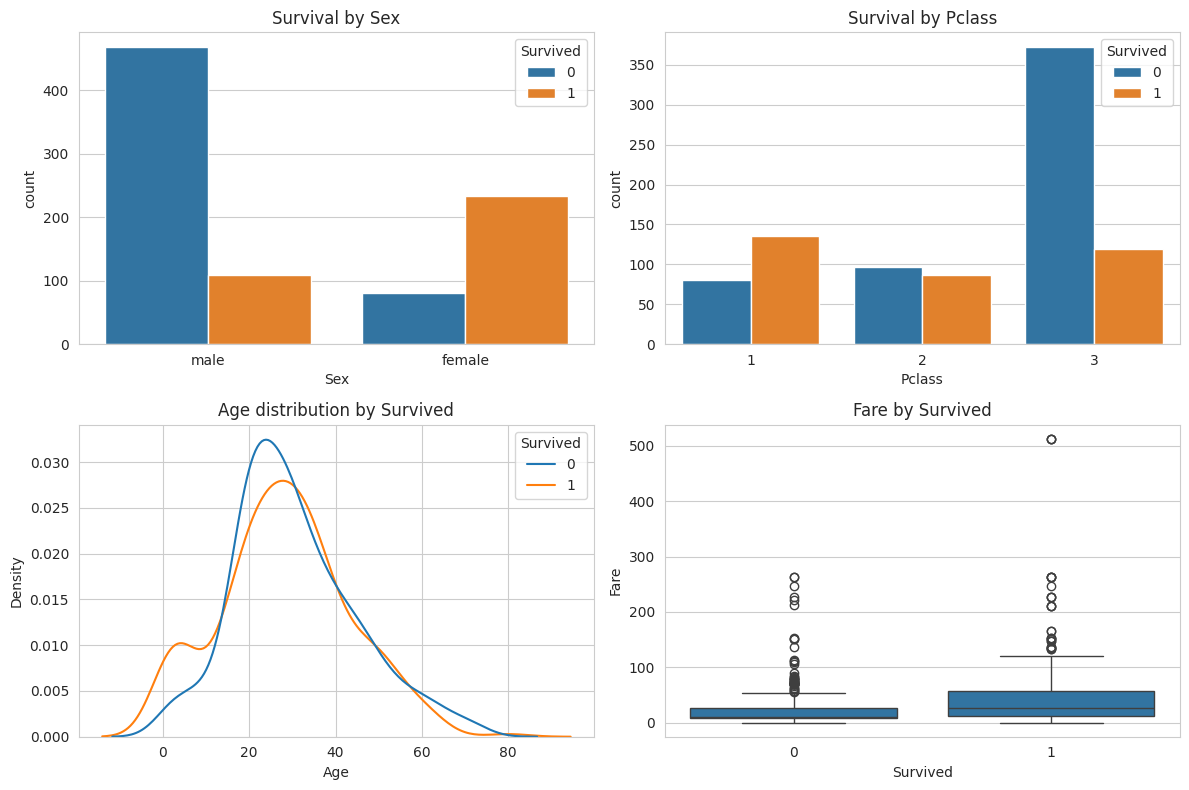

In [24]:
# CELDA 4 - EDA (tests + plots)
# 1) Contingency Sex vs Survived (chi2)
ct_sex = pd.crosstab(train['Sex'], train['Survived'])
chi2_sex, p_sex, _, _ = chi2_contingency(ct_sex)
print("Sex vs Survived — chi2: %.3f p: %.5f" % (chi2_sex, p_sex))
display(ct_sex)

# 2) Contingency Pclass vs Survived (chi2)
ct_pclass = pd.crosstab(train['Pclass'], train['Survived'])
chi2_pc, p_pc, _, _ = chi2_contingency(ct_pclass)
print("Pclass vs Survived — chi2: %.3f p: %.5f" % (chi2_pc, p_pc))
display(ct_pclass)

# 3) Age distribution by Survived (Mann-Whitney)
age_survived = train.loc[train['Survived']==1, 'Age'].dropna()
age_dead = train.loc[train['Survived']==0, 'Age'].dropna()
stat_age, p_age = mannwhitneyu(age_survived, age_dead, alternative='two-sided')
print("Age Mann-Whitney p-value:", p_age)
print("Median Age survived:", age_survived.median(), "dead:", age_dead.median())

# 4) Plots: survival rate by Sex and Pclass; Age KDE; Fare boxplot by Survived
fig, axes = plt.subplots(2,2, figsize=(12,8))
sns.countplot(data=train, x='Sex', hue='Survived', ax=axes[0,0])
axes[0,0].set_title('Survival by Sex')

sns.countplot(data=train, x='Pclass', hue='Survived', ax=axes[0,1])
axes[0,1].set_title('Survival by Pclass')

sns.kdeplot(data=train, x='Age', hue='Survived', common_norm=False, ax=axes[1,0])
axes[1,0].set_title('Age distribution by Survived')

sns.boxplot(data=train, x='Survived', y='Fare', ax=axes[1,1])
axes[1,1].set_title('Fare by Survived')

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency, ks_2samp
